In [1]:
!pip install -U --quiet langchain langchain_community chromadb  langchain-google-vertexai
!pip install --quiet "unstructured[all-docs]" pypdf pillow pydantic lxml pillow matplotlib chromadb tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
#TODO : ENter project and location
PROJECT_ID = "q-and-a-with-multi-model-rag"
REGION = "us-central1"

from google.colab import auth
auth.authenticate_user()

In [2]:
import vertexai
vertexai.init(project = PROJECT_ID , location = REGION)

In [3]:
import logging
import zipfile
import requests

logging.basicConfig(level=logging.INFO)

data_url = "https://storage.googleapis.com/benchmarks-artifacts/langchain-docs-benchmarking/cj.zip"
result = requests.get(data_url)
filename = "cj.zip"
with open(filename, "wb") as file:
   file.write(result.content)

with zipfile.ZipFile(filename, "r") as zip_ref:
   zip_ref.extractall()

In [4]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("./cj/cj.pdf")
docs = loader.load()
tables = []
texts = [d.page_content for d in docs]

In [5]:
texts[0]

'11/14/23, 8:35 PM Clouded Judgement 11.10.23 - by Jamin Ball\nhttps://cloudedjudgement.substack.com/p/clouded-judgement-111023 1/21Clouded Judgement 11.10.23 - OpenAI\nUpdates + Datadog Gives the All-Clear?\nJAMIN BALL\nNOV 10, 2023\n2 Share\nEvery week I’ll provide updates on the latest trends in cloud so\x00ware companies. Follow along to\nstay up to date!\nOpen AI U pdates\nOpenAI had their big developer day this week, and I wanted to call out two key announcements\n(and trends): increasing context windows and decreasing costs.\nWhen I think about the monetization of AI (and which “layers” monetize \x00rst) I’ve always\nthought it would follow the below order, with each layer lagging the one that comes before it.\n1. Raw silicon (chips like Nvidia bought in large quantities to build out infra to service\nupcoming demand).\n2. Model providers (OpenAI, Anthropic, etc as companies start building out AI).\n35\nType your email... Subscribe'

In [6]:
len(texts)

21

In [9]:
from langchain_google_vertexai import VertexAI , ChatVertexAI , VertexAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda

In [10]:
# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
   """
   Summarize text elements
   texts: List of str
   tables: List of str
   summarize_texts: Bool to summarize texts
   """

   # Prompt
   prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
   These summaries will be embedded and used to retrieve the raw text or table elements. \
   Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
   prompt = PromptTemplate.from_template(prompt_text)
   empty_response = RunnableLambda(
       lambda x: AIMessage(content="Error processing document")
   )
   # Text summary chain
   model = VertexAI(
       temperature=0, model_name="gemini-pro", max_output_tokens=1024
   ).with_fallbacks([empty_response])
   summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

   # Initialize empty summaries
   text_summaries = []
   table_summaries = []

   # Apply to text if texts are provided and summarization is requested
   if texts and summarize_texts:
       text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
   elif texts:
       text_summaries = texts

   # Apply to tables if tables are provided
   if tables:
       table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

   return text_summaries, table_summaries


# Get text summaries
text_summaries, table_summaries = generate_text_summaries(
   texts, tables, summarize_texts=True
)

text_summaries[0]

'## Clouded Judgement 11.10.23: OpenAI Updates\n\nThis article discusses OpenAI\'s developer day announcements, focusing on two key trends: increasing context windows and decreasing costs. The author believes these trends will impact the monetization of AI, with raw silicon being the first layer to monetize, followed by model providers like OpenAI. \n\n**Key Takeaways:**\n\n* OpenAI increased context windows and decreased costs for their models.\n* The author believes this will impact the monetization of AI, with raw silicon being the first layer to monetize, followed by model providers.\n\n**Additional Information:**\n\n* This article was published on November 10, 2023.\n* The author is Jamin Ball.\n* The article is part of the "Clouded Judgement" series.\n* The article can be found at https://cloudedjudgement.substack.com/p/clouded-judgement-111023. \n'

In [11]:
import base64
import os

from langchain_core.messages import HumanMessage

In [12]:
def encode_image(image_path):
   """Getting the base64 string"""
   with open(image_path, "rb") as image_file:
       return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
   """Make image summary"""
   model = ChatVertexAI(model_name="gemini-pro-vision", max_output_tokens=1024)

   msg = model(
       [
           HumanMessage(
               content=[
                   {"type": "text", "text": prompt},
                   {
                       "type": "image_url",
                       "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                   },
               ]
           )
       ]
   )
   return msg.content


def generate_img_summaries(path):
   """
   Generate summaries and base64 encoded strings for images
   path: Path to list of .jpg files extracted by Unstructured
   """

   # Store base64 encoded images
   img_base64_list = []

   # Store image summaries
   image_summaries = []

   # Prompt
   prompt = """You are an assistant tasked with summarizing images for retrieval. \
   These summaries will be embedded and used to retrieve the raw image. \
   Give a concise summary of the image that is well optimized for retrieval."""

   # Apply to images
   for img_file in sorted(os.listdir(path)):
       if img_file.endswith(".jpg"):
           img_path = os.path.join(path, img_file)
           base64_image = encode_image(img_path)
           img_base64_list.append(base64_image)
           image_summaries.append(image_summarize(base64_image, prompt))

   return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries("./cj")

len(img_base64_list)

len(image_summaries)

image_summaries[0]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


' The image shows a line chart of EV/NTM revenue multiples over time. The three lines represent different growth rates. The high growth median is the highest line, followed by the mid growth median and the low growth median. The chart shows that EV/NTM revenue multiples have been increasing over time, with the high growth median line showing the highest increase.'

In [13]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

In [14]:
def create_multi_vector_retriever(
   vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
   """
   Create retriever that indexes summaries, but returns raw images or texts
   """

   # Initialize the storage layer
   store = InMemoryStore()
   id_key = "doc_id"

   # Create the multi-vector retriever
   retriever = MultiVectorRetriever(
       vectorstore=vectorstore,
       docstore=store,
       id_key=id_key,
   )

   # Helper function to add documents to the vectorstore and docstore
   def add_documents(retriever, doc_summaries, doc_contents):
       doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
       summary_docs = [
           Document(page_content=s, metadata={id_key: doc_ids[i]})
           for i, s in enumerate(doc_summaries)
       ]
       retriever.vectorstore.add_documents(summary_docs)
       retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

   # Add texts, tables, and images
   # Check that text_summaries is not empty before adding
   if text_summaries:
       add_documents(retriever, text_summaries, texts)
   # Check that table_summaries is not empty before adding
   if table_summaries:
       add_documents(retriever, table_summaries, tables)
   # Check that image_summaries is not empty before adding
   if image_summaries:
       add_documents(retriever, image_summaries, images)

   return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
   collection_name="mm_rag_cj_blog",
   embedding_function=VertexAIEmbeddings(model_name="textembedding-gecko@latest"),
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
   vectorstore,
   text_summaries,
   texts,
   table_summaries,
   tables,
   image_summaries,
   img_base64_list,
)


In [15]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
   """Disply base64 encoded string as image"""
   # Create an HTML img tag with the base64 string as the source
   image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
   # Display the image by rendering the HTML
   display(HTML(image_html))


def looks_like_base64(sb):
   """Check if the string looks like base64"""
   return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
   """
   Check if the base64 data is an image by looking at the start of the data
   """
   image_signatures = {
       b"\xFF\xD8\xFF": "jpg",
       b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
       b"\x47\x49\x46\x38": "gif",
       b"\x52\x49\x46\x46": "webp",
   }
   try:
       header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
       for sig, format in image_signatures.items():
           if header.startswith(sig):
               return True
       return False
   except Exception:
       return False


def resize_base64_image(base64_string, size=(128, 128)):
   """
   Resize an image encoded as a Base64 string
   """
   # Decode the Base64 string
   img_data = base64.b64decode(base64_string)
   img = Image.open(io.BytesIO(img_data))

   # Resize the image
   resized_img = img.resize(size, Image.LANCZOS)

   # Save the resized image to a bytes buffer
   buffered = io.BytesIO()
   resized_img.save(buffered, format=img.format)

   # Encode the resized image to Base64
   return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
   """
   Split base64-encoded images and texts
   """
   b64_images = []
   texts = []
   for doc in docs:
       # Check if the document is of type Document and extract page_content if so
       if isinstance(doc, Document):
           doc = doc.page_content
       if looks_like_base64(doc) and is_image_data(doc):
           doc = resize_base64_image(doc, size=(1300, 600))
           b64_images.append(doc)
       else:
           texts.append(doc)
   if len(b64_images) > 0:
       return {"images": b64_images[:1], "texts": []}
   return {"images": b64_images, "texts": texts}

In [16]:
def img_prompt_func(data_dict):
   """
   Join the context into a single string
   """
   formatted_texts = "\n".join(data_dict["context"]["texts"])
   messages = []

   # Adding the text for analysis
   text_message = {
       "type": "text",
       "text": (
           "You are financial analyst tasking with providing investment advice.\n"
           "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
           "Use this information to provide investment advice related to the user question. \n"
           f"User-provided question: {data_dict['question']}\n\n"
           "Text and / or tables:\n"
           f"{formatted_texts}"
       ),
   }
   messages.append(text_message)
   # Adding image(s) to the messages if present
   if data_dict["context"]["images"]:
       for image in data_dict["context"]["images"]:
           image_message = {
               "type": "image_url",
               "image_url": {"url": f"data:image/jpeg;base64,{image}"},
           }
           messages.append(image_message)
   return [HumanMessage(content=messages)]


In [17]:
def multi_modal_rag_chain(retriever):
   """
   Multi-modal RAG chain
   """

   # Multi-modal LLM
   model = ChatVertexAI(
       temperature=0, model_name="gemini-pro-vision", max_output_tokens=1024
   )

   # RAG pipeline
   chain = (
       {
           "context": retriever | RunnableLambda(split_image_text_types),
           "question": RunnablePassthrough(),
       }
       | RunnableLambda(img_prompt_func)
       | model
       | StrOutputParser()
   )

   return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [18]:
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=1)

# We get relevant docs
len(docs)

docs

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAMRBQkDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA


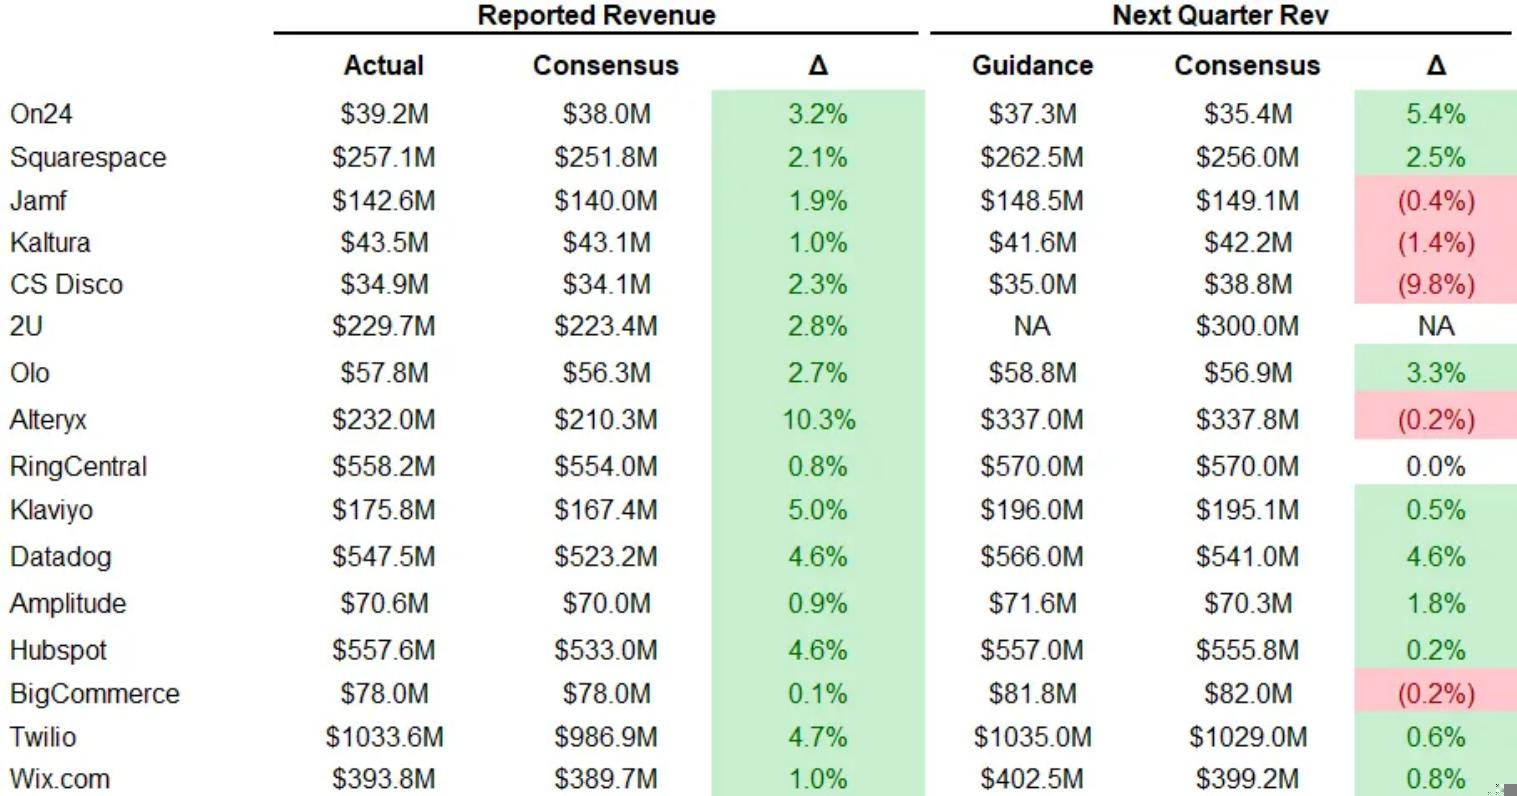

In [19]:
plt_img_base64(docs[3])

In [20]:
result = chain_multimodal_rag.invoke(query)

from IPython.display import Markdown as md
md(result)

 | Company | EV / NTM | NTM Rev Growth |
|---|---|---|
| MongoDB | 21.2x | 36% |
| Cloudflare | 24.9x | 51% |
| Datadog | 29.1x | 64% |